# Acknowledgement:
This implementation of Liquid Time-Constant (LTC) Liquid Neural Networks is based on the original work of R. Hasani. Please refer to the original repository and paper below:

[LTCCell Implementation](https://github.com/raminmh/liquid_time_constant_networks)

[Liquid Time-Constant Networks Paper](https://arxiv.org/abs/2006.04439)

# Dataset:
The dataset utilized for this implementation comprises 69,480 weather measurements collected at 30-minute intervals from multiple sites by [UK Power Networks](https://data.london.gov.uk/dataset/photovoltaic-pv-solar-panel-energy-generation-data-2nlqm/) over several months in 2014. The target variable is solar energy, supported by 37 features including meteorological factors (e.g., outdoor temperature, humidity, dew point, wind speed/direction, barometric pressure, rainfall, solar radiation, evapotranspiration) and contextual variables (e.g., heating/cooling degree days, indoor temperature/humidity, wind samples, temporal data like time, month, date, hour, and site location).

Preprocessing involved:

*  Converting 'hour' and 'wind direction' into cyclical features
using sine and cosine transformations.
*  One-hot encoding the 'site' column.
*  Dropping redundant columns (site, date, time, month, wind direction, high wind direction), resulting in 39 features total.
*  Splitting the data into 70% training, 15% validation, and 15% test sets.
*  Normalizing features and target using MinMaxScaler (0-1 range).

# Importing Libraries:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from enum import Enum

# Defining enums for solver and mapping types:

In [ ]:
class ODESolver(Enum):
    SemiImplicit = "semi_implicit"
    Explicit = "explicit"
    RungeKutta = "runge_kutta"

class MappingType(Enum):
    Identity = "identity"
    Linear = "linear"
    Affine = "affine"

# Creating the LTCCell:
The LTC model is implemented using a custom LTCCell class within a Keras sequential architecture, based on continuous-time dynamics. The cell's hidden state evolves according to an ODE for each unit $i$: $\frac{dh_i}{dt} = -\frac{h_i}{\tau_i} + a_i$, where $\tau_i = \text{softplus}(v_i)$ (with $v_i$ as a trainable parameter ensuring positivity), and $a_i = \text{ReLU}(W_x x + W_h h + b)$ represents the activation output driven by input $x$, weights $W_x$ and $W_h$, bias $b$, and ReLU for sparsity and non-negativity.


While there are other options that you can use for the ODE solver, in this implementation, I used the fourth-order Runge-Kutta (RK4) method to integrate this ODE and to handle stifness, with a time step $\Delta t = \frac{1}{3}$, resulting in 3 sub-steps per input for stability and improved trajectory fidelity over methods like Euler. This includes an affine transformation of inputs via kernel and bias terms in $a_i$ computation.

In [ ]:
class LTCCell(tf.keras.layers.Layer):
    def __init__(
        self,
        num_units,
        input_mapping=MappingType.Affine,
        solver=ODESolver.SemiImplicit,
        ode_solver_unfolds=6,
        activation=tf.nn.tanh,
        **kwargs
    ):
        super(LTCCell, self).__init__(**kwargs)
        self._num_units = num_units
        self._input_mapping = input_mapping
        self._solver = solver
        self._ode_solver_unfolds = ode_solver_unfolds
        self._activation = activation

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self._num_units),
            initializer="glorot_uniform",
            name="kernel"
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self._num_units, self._num_units),
            initializer="orthogonal",
            name="recurrent_kernel"
        )
        self.bias_f = self.add_weight(
            shape=(self._num_units,),
            initializer="zeros",
            name="bias_f"
        )
        self.tau = self.add_weight(
            shape=(self._num_units,),
            initializer="ones",
            trainable=True,
            name="tau"
        )
        self.A = self.add_weight(
            shape=(self._num_units,),
            initializer="zeros",
            name="A"
        )
        self.built = True

    def ode_func(self, x, inputs, tau_positive):
        f = self._activation(
            tf.matmul(inputs, self.kernel) +
            tf.matmul(x, self.recurrent_kernel) +
            self.bias_f
        )
        dx_dt = -(1.0 / tau_positive + f) * x + f * self.A
        return dx_dt

    def call(self, inputs, states):
        prev_state = states[0]
        dt = 1.0 / self._ode_solver_unfolds
        tau_positive = tf.nn.softplus(self.tau)
        x = prev_state

        if self._solver == ODESolver.SemiImplicit:
            for _ in range(self._ode_solver_unfolds):
                f = self._activation(
                    tf.matmul(inputs, self.kernel) +
                    tf.matmul(x, self.recurrent_kernel) +
                    self.bias_f
                )
                numerator = x + dt * (f * self.A)
                denominator = 1.0 + dt * (1.0 / tau_positive + f)
                x = numerator / denominator
        elif self._solver == ODESolver.RungeKutta:
            for _ in range(self._ode_solver_unfolds):
                k1 = self.ode_func(x, inputs, tau_positive)
                k2 = self.ode_func(x + 0.5 * dt * k1, inputs, tau_positive)
                k3 = self.ode_func(x + 0.5 * dt * k2, inputs, tau_positive)
                k4 = self.ode_func(x + dt * k3, inputs, tau_positive)
                x = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        else:
            raise ValueError(f"Unsupported solver type: {self._solver}")

        output = x
        return output, [output]

    def get_config(self):
        config = super(LTCCell, self).get_config()
        config.update({
            "num_units": self._num_units,
            "input_mapping": self._input_mapping.value,
            "solver": self._solver.value,
            "ode_solver_unfolds": self._ode_solver_unfolds,
            "activation": tf.keras.activations.serialize(self._activation)
        })
        return config

# Loading and Preprocessing Dataset:

In [ ]:
data = pd.read_csv('Weather Data 2014-11-30.csv', low_memory=False)

# Replacing '---' with NaN for missing values
data.replace('---', np.nan, inplace=True)

# Defining columns that should be numeric
numeric_cols = [
    'Hour', 'TempOut', 'HiTemp', 'LowTemp', 'OutHum', 'DewPt', 'WindSpeed',
    'WindRun', 'HiSpeed', 'WindChill', 'HeatIndex', 'THWIndex', 'THSWIndex',
    'Bar', 'Rain', 'RainRate', 'SolarRad', 'SolarEnergy', 'HiSolarRad',
    'HeatD-D', 'CoolD-D', 'InTemp', 'InHum', 'InDew', 'InHeat', 'InEMC',
    'InAirDensity', 'ET', 'WindSamp', 'WindTx', 'ISSRecept', 'ArcInt'
]

# Converting numeric columns to float, coercing errors to NaN
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handling time-related columns
# Since this is a CTRNN, we'll use Hour as a cyclical feature and drop redundant time columns
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

# Handling categorical variables
# One-hot encode 'Site'
site_encoded = pd.get_dummies(data['Site'], prefix='Site')
data = pd.concat([data, site_encoded], axis=1)

# Encoding 'WindDir' using sine and cosine components
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW',
              'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
angles = np.linspace(0, 2 * np.pi, len(directions), endpoint=False)
dir_to_angle = dict(zip(directions, angles))
data['WindDir_rad'] = data['WindDir'].map(dir_to_angle)
data['WindDir_sin'] = np.sin(data['WindDir_rad'])
data['WindDir_cos'] = np.cos(data['WindDir_rad'])

# Droping original and redundant columns
columns_to_drop = ['Site', 'Date', 'Time', 'Month', 'WindDir', 'WindDir_rad',
                   'HiDir']  # HiDir is redundant with WindDir
data = data.drop(columns=columns_to_drop)

# Droping rows where 'SolarEnergy' is NaN
data = data.dropna(subset=['SolarEnergy'])

# Defining features and target
target = data['SolarEnergy'].astype(float)
features = data.drop(columns=['SolarEnergy'])

# Droping all-NaN columns in features
features = features.dropna(axis=1, how='all')

# Filling remaining NaNs in features
features = features.ffill().bfill()

# Droping any remaining rows with NaNs and align target
features = features.dropna()
target = target.loc[features.index]

# Verify no NaNs
assert not features.isnull().any().any(), "Features still contain NaN values"
assert not target.isnull().any(), "Target still contains NaN values"

# Splitting features and target
x = features.values
t = target.values.reshape(-1, 1)

# Defining train, validation, and test sizes
total_rows = len(x)
train_ratio = 0.7
val_ratio = 0.15
train_size = int(train_ratio * total_rows)
val_size = int(val_ratio * total_rows)
test_size = total_rows - train_size - val_size

# Splitting the data
x_train_raw = x[:train_size]
x_val_raw = x[train_size:train_size + val_size]
x_test_raw = x[train_size + val_size:]
t_train_raw = t[:train_size]
t_val_raw = t[train_size:train_size + val_size]
t_test_raw = t[train_size + val_size:]

# Scaling the data
scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()
x_scaled_entire = scaler_x.fit_transform(x)
t_scaled_entire = scaler_t.fit_transform(t)
x_train_scaled = scaler_x.transform(x_train_raw)
x_val_scaled = scaler_x.transform(x_val_raw)
x_test_scaled = scaler_x.transform(x_test_raw)
t_train_scaled = scaler_t.transform(t_train_raw)
t_val_scaled = scaler_t.transform(t_val_raw)
t_test_scaled = scaler_t.transform(t_test_raw)

# Updating number of features
num_features = x_train_scaled.shape[1]

# Reshaping data into single sequences
X_train_reshaped = x_train_scaled.reshape(1, train_size, num_features)
Y_train_reshaped = t_train_scaled.reshape(1, train_size, 1)
X_val_reshaped = x_val_scaled.reshape(1, val_size, num_features)
Y_val_reshaped = t_val_scaled.reshape(1, val_size, 1)

# Building and Training the Model:

In [ ]:
num_units = 128
rnn_cell = LTCCell(num_units, input_mapping=MappingType.Affine, ode_solver_unfolds=3,
                  activation=tf.nn.relu, solver=ODESolver.RungeKutta)

model = tf.keras.Sequential()
model.add(layers.Input(shape=(None, num_features)))
model.add(layers.RNN(rnn_cell, return_sequences=True))
model.add(layers.Dense(1))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=1000, batch_size=1,
                    validation_data=(X_val_reshaped, Y_val_reshaped),
                    callbacks=[early_stop, lr_scheduler])

# Making Predictions and Results:

<ipython-input-1-88ac552855a6>:131: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('---', np.nan, inplace=True)


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.0398 - val_loss: 0.0650 - learning_rate: 0.0100
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0358 - val_loss: 0.0559 - learning_rate: 0.0100
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0316 - val_loss: 0.0467 - learning_rate: 0.0100
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0302 - val_loss: 0.0429 - learning_rate: 0.0100
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0309 - val_loss: 0.0414 - learning_rate: 0.0100
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0289 - val_loss: 0.0412 - learning_rate: 0.0100
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0264 - val_loss: 0.0416 - learning_rate: 0.0100
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0249 - val_loss: 0.0409 - learning_rate: 0.0100
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0236 - val_loss: 0.0382 - learning_rate: 0.0100
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━

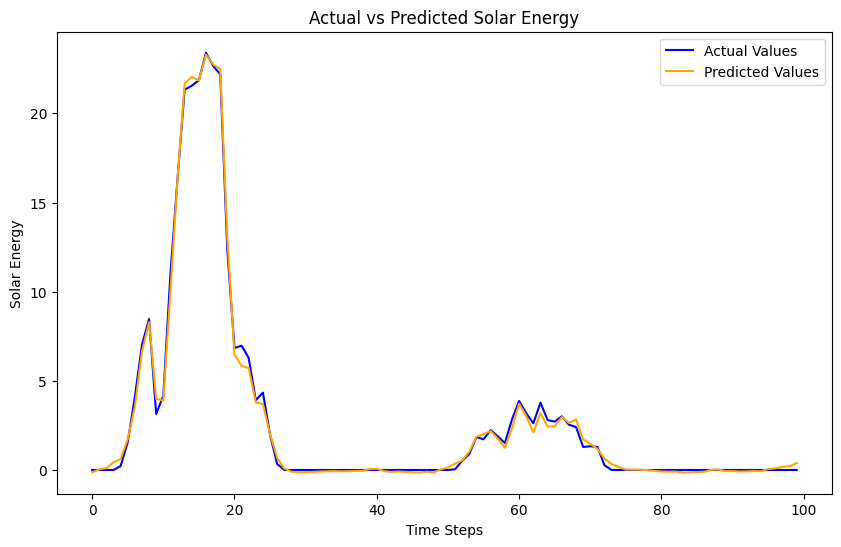

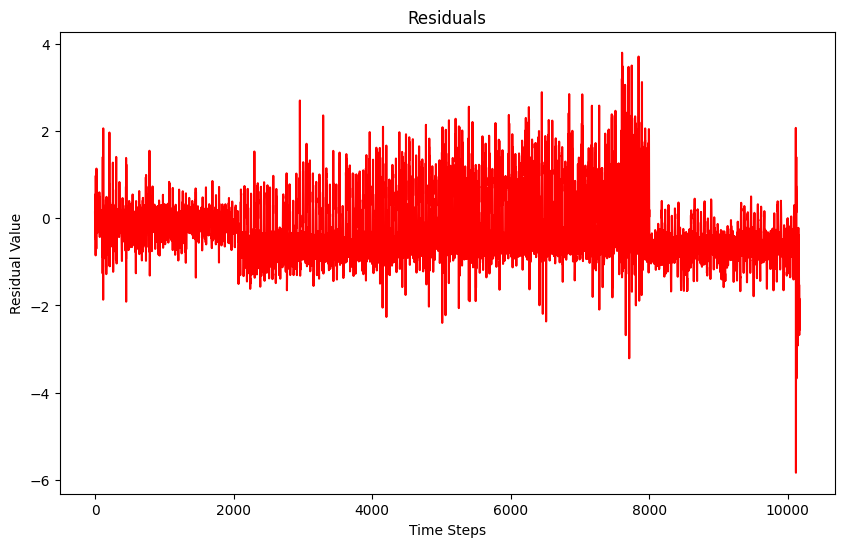

In [ ]:
# Preparing full data for prediction
x_full_selected = x_scaled_entire
X_full_reshaped = x_full_selected.reshape(1, total_rows, num_features)

# Make predictions
predictions_full = model.predict(X_full_reshaped)
predicted_test = predictions_full[0, train_size + val_size:, 0]

# Inverse transform predictions and actual values
predicted_values = scaler_t.inverse_transform(predicted_test.reshape(-1, 1)).flatten()
actual_values = t_test_raw.flatten()

# Calculating metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting actual vs predicted values (first 100 time steps)
plt.figure(figsize=(10, 6))
plt.plot(actual_values[:100], label='Actual Values', color='blue')
plt.plot(predicted_values[:100], label='Predicted Values', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Solar Energy')
plt.title('Actual vs Predicted Solar Energy')
plt.legend()
plt.show()

# Plotting residuals
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='red')
plt.title('Residuals')
plt.xlabel('Time Steps')
plt.ylabel('Residual Value')
plt.show()